In [91]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import os
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

After pulling in the dataset, I need to remove 'statewide unallocated', and need to ensure that the 'Date' column is in fact a date.

In [20]:
data=pd.read_csv("../../../../data/stage_2/superdataset.csv")

#Removing statewide unallocated
data = data[data.County_Name != 'statewide unallocated']

#Ensuring data is datetime
data['Date']=pd.to_datetime(data['Date'])
data

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
748,1001,autauga county,AL,2020-01-22,0,0,55869
749,1001,autauga county,AL,2020-01-23,0,0,55869
750,1001,autauga county,AL,2020-01-24,0,0,55869
751,1001,autauga county,AL,2020-01-25,0,0,55869
752,1001,autauga county,AL,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...
2346471,56045,weston county,WY,2022-02-03,1491,17,6927
2346472,56045,weston county,WY,2022-02-04,1496,17,6927
2346473,56045,weston county,WY,2022-02-05,1496,17,6927
2346474,56045,weston county,WY,2022-02-06,1496,17,6927


I now need to pull data for Indiana, as that will be my state of choice for additional analysis. I also need to calculate the difference in cases and deaths, as opposed to the aggregate. Since I initially only want to look at it from a state level, I'm gonna first remove any reference to counties, and aggregate the daily information.

In [3]:
indiana_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
indiana_covid_agg=indiana_covid.drop(columns=['countyFIPS','County_Name','State','population'])
indiana_covid_agg=indiana_covid_agg.groupby('Date').agg('sum')
indiana_covid_agg

,Confirmed,Deaths
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2022-02-03,1646804,21666
2022-02-04,1651124,21712
2022-02-05,1651124,21712


We now have aggregated daily data for all of Indiana. Before moving forward, we're going to need Indiana's total population for a later calculation, so let's get that now.

In [4]:
#Summing unique population values in Indiana
indiana_pop=indiana_covid.population.drop_duplicates().sum()
indiana_pop

6732219

Now we can difference out our cases and deaths to get just the new cases and deaths each day. 

In [5]:
#New Cases
indiana_covid_agg['New_Confirmed']=indiana_covid_agg['Confirmed'].diff()

#New Deaths
indiana_covid_agg['New_Deaths']=indiana_covid_agg['Deaths'].diff()

#Removing Unneeded columns
indiana_covid_agg=indiana_covid_agg.drop(columns=["Confirmed",'Deaths'])
indiana_covid_agg

,New_Confirmed,New_Deaths
Date,,
2020-01-22,NaN,NaN
2020-01-23,0.0,0.0
2020-01-24,0.0,0.0
2020-01-25,0.0,0.0
2020-01-26,0.0,0.0
...,...,...
2022-02-03,6626.0,68.0
2022-02-04,4320.0,46.0
2022-02-05,0.0,0.0


I need to cut off a few of the first dates in January, in order for future resampling to work as intended. The new data will start at January 26th, 2022.

In [6]:
indiana_covid_agg = indiana_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
indiana_covid_agg

,New_Confirmed,New_Deaths
Date,,
2020-01-26,0.0,0.0
2020-01-27,0.0,0.0
2020-01-28,0.0,0.0
2020-01-29,0.0,0.0
2020-01-30,0.0,0.0
...,...,...
2022-02-03,6626.0,68.0
2022-02-04,4320.0,46.0
2022-02-05,0.0,0.0


Next, I need to convert the daily information to weekly for new cases and deaths. Removing the dates above results in a clean average for each week. I had to reset the index I used before to get the resample to work as intended.

In [7]:
indiana_weekly_avg = indiana_covid_agg
indiana_weekly_avg.reset_index(inplace=True)

#Using resample to aggregate daily to weekly
indiana_weekly_avg = indiana_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
indiana_weekly_avg.New_Confirmed = indiana_weekly_avg.New_Confirmed.round()
indiana_weekly_avg.New_Deaths = indiana_weekly_avg.New_Deaths.round()
indiana_weekly_avg

,New_Confirmed,New_Deaths
Date,,
2020-01-26,0.0,0.0
2020-02-02,0.0,0.0
2020-02-09,0.0,0.0
2020-02-16,0.0,0.0
2020-02-23,0.0,0.0
...,...,...
2022-01-09,13791.0,87.0
2022-01-16,14098.0,75.0
2022-01-23,11369.0,79.0


Now that we have weekly information, we can use the describe function to get the descriptive statistics for both cases and deaths

In [8]:
indiana_weekly_avg.describe()

,New_Confirmed,New_Deaths
count,107.000000,107.000000
mean,2228.056075,29.495327
std,2746.507531,32.089019
min,0.000000,0.000000
25%,518.500000,10.000000
50%,1001.000000,20.000000
75%,2878.000000,42.000000
max,14098.000000,255.000000


Indiana apparently had an average weekly case of over 2200 covid cases and nearly 30 covid deaths. Now we need to normalize the data by population.

In [9]:
indiana_weekly_avg['New_Confirmed_per_100000'] = indiana_weekly_avg.New_Confirmed/indiana_pop *100000
indiana_weekly_avg['New_Deaths_per_100000'] = indiana_weekly_avg.New_Deaths/indiana_pop *100000
x=len(indiana_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if indiana_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        indiana_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if indiana_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        indiana_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
indiana_weekly_avg['lognormal_Confirmed'] = np.log10(indiana_weekly_avg.New_Confirmed_per_100000)
indiana_weekly_avg['lognormal_Deaths'] = np.log10(indiana_weekly_avg.New_Deaths_per_100000)
indiana_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,13791.0,87.0,204.850733,1.292293,2.311438,0.111361
2022-01-16,14098.0,75.0,209.410894,1.114046,2.320999,0.046903
2022-01-23,11369.0,79.0,168.874483,1.173462,2.227564,0.069469


We now need to do this for 5 other states. I'll be using states located near to Indiana: Ohio, Illinois, Michigan, Kentucky, and Wisconsin. As the code will be the exact same other than the name of the state, the next five lines will represent each state's total code, so apologies for the large batches of code.

Ohio:

In [92]:
ohio_covid = data[data["State"].isin(["OH"])].reset_index(drop=True)
ohio_pop=ohio_covid.population.drop_duplicates().sum()
ohio_covid_agg=ohio_covid.drop(columns=['countyFIPS','County_Name','State','population'])
ohio_covid_agg=ohio_covid_agg.groupby('Date').agg('sum')

#New Cases
ohio_covid_agg['New_Confirmed']=ohio_covid_agg['Confirmed'].diff()

#New Deaths
ohio_covid_agg['New_Deaths']=ohio_covid_agg['Deaths'].diff()

#Removing Unneeded columns
ohio_covid_agg=ohio_covid_agg.drop(columns=["Confirmed",'Deaths'])
ohio_covid_agg = ohio_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
ohio_weekly_avg = ohio_covid_agg
ohio_weekly_avg.reset_index(inplace=True)

#Resampling
ohio_weekly_avg = ohio_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
ohio_weekly_avg.New_Confirmed = ohio_weekly_avg.New_Confirmed.round()
ohio_weekly_avg.New_Deaths = ohio_weekly_avg.New_Deaths.round()
ohio_weekly_avg['New_Confirmed_per_100000'] = ohio_weekly_avg.New_Confirmed/ohio_pop *100000
ohio_weekly_avg['New_Deaths_per_100000'] = ohio_weekly_avg.New_Deaths/ohio_pop *100000
x=len(ohio_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if ohio_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        ohio_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if ohio_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        ohio_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
ohio_weekly_avg['lognormal_Confirmed'] = np.log10(ohio_weekly_avg.New_Confirmed_per_100000)
ohio_weekly_avg['lognormal_Deaths'] = np.log10(ohio_weekly_avg.New_Deaths_per_100000)
ohio_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,22266.0,121.0,190.485153,1.035152,2.279861,0.015004
2022-01-16,24696.0,152.0,211.273751,1.300357,2.324846,0.114063
2022-01-23,11692.0,155.0,100.024809,1.326022,2.000108,0.122551


Illinois:

In [93]:
illinois_covid = data[data["State"].isin(["IL"])].reset_index(drop=True)
illinois_pop=illinois_covid.population.drop_duplicates().sum()
illinois_covid_agg=illinois_covid.drop(columns=['countyFIPS','County_Name','State','population'])
illinois_covid_agg=illinois_covid_agg.groupby('Date').agg('sum')

#New Cases
illinois_covid_agg['New_Confirmed']=illinois_covid_agg['Confirmed'].diff()

#New Deaths
illinois_covid_agg['New_Deaths']=illinois_covid_agg['Deaths'].diff()

#Removing Unneeded columns
illinois_covid_agg=illinois_covid_agg.drop(columns=["Confirmed",'Deaths'])
illinois_covid_agg = illinois_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
illinois_weekly_avg = illinois_covid_agg
illinois_weekly_avg.reset_index(inplace=True)

#Resampling
illinois_weekly_avg = illinois_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
illinois_weekly_avg.New_Confirmed = illinois_weekly_avg.New_Confirmed.round()
illinois_weekly_avg.New_Deaths = illinois_weekly_avg.New_Deaths.round()
illinois_weekly_avg['New_Confirmed_per_100000'] = illinois_weekly_avg.New_Confirmed/illinois_pop *100000
illinois_weekly_avg['New_Deaths_per_100000'] = illinois_weekly_avg.New_Deaths/illinois_pop *100000
x=len(illinois_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if illinois_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        illinois_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if illinois_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        illinois_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
illinois_weekly_avg['lognormal_Confirmed'] = np.log10(illinois_weekly_avg.New_Confirmed_per_100000)
illinois_weekly_avg['lognormal_Deaths'] = np.log10(illinois_weekly_avg.New_Deaths_per_100000)
illinois_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,29973.0,107.0,236.532697,0.844393,2.373891,-0.073455
2022-01-16,27590.0,110.0,217.727192,0.868068,2.337913,-0.061446
2022-01-23,13236.0,120.0,104.452233,0.946983,2.018918,-0.023658


Michigan:

In [94]:
michigan_covid = data[data["State"].isin(["MI"])].reset_index(drop=True)
michigan_pop=michigan_covid.population.drop_duplicates().sum()
michigan_covid_agg=michigan_covid.drop(columns=['countyFIPS','County_Name','State','population'])
michigan_covid_agg=michigan_covid_agg.groupby('Date').agg('sum')

#New Cases
michigan_covid_agg['New_Confirmed']=michigan_covid_agg['Confirmed'].diff()

#New Deaths
michigan_covid_agg['New_Deaths']=michigan_covid_agg['Deaths'].diff()

#Removing Unneeded columns
michigan_covid_agg=michigan_covid_agg.drop(columns=["Confirmed",'Deaths'])
michigan_covid_agg = michigan_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
michigan_weekly_avg = michigan_covid_agg
michigan_weekly_avg.reset_index(inplace=True)

#Resampling
michigan_weekly_avg = michigan_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
michigan_weekly_avg.New_Confirmed = michigan_weekly_avg.New_Confirmed.round()
michigan_weekly_avg.New_Deaths = michigan_weekly_avg.New_Deaths.round()
michigan_weekly_avg['New_Confirmed_per_100000'] = michigan_weekly_avg.New_Confirmed/michigan_pop *100000
michigan_weekly_avg['New_Deaths_per_100000'] = michigan_weekly_avg.New_Deaths/michigan_pop *100000
x=len(michigan_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if michigan_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        michigan_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if michigan_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        michigan_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
michigan_weekly_avg['lognormal_Confirmed'] = np.log10(michigan_weekly_avg.New_Confirmed_per_100000)
michigan_weekly_avg['lognormal_Deaths'] = np.log10(michigan_weekly_avg.New_Deaths_per_100000)
michigan_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,18099.0,108.0,181.228188,1.081421,2.258226,0.033995
2022-01-16,19670.0,113.0,196.958863,1.131487,2.294376,0.053650
2022-01-23,15532.0,99.0,155.524406,0.991303,2.191799,-0.003794


Kentucky:

In [13]:
kentucky_covid = data[data["State"].isin(["KY"])].reset_index(drop=True)
kentucky_pop=kentucky_covid.population.drop_duplicates().sum()
kentucky_covid_agg=kentucky_covid.drop(columns=['countyFIPS','County_Name','State','population'])
kentucky_covid_agg=kentucky_covid_agg.groupby('Date').agg('sum')

#New Cases
kentucky_covid_agg['New_Confirmed']=kentucky_covid_agg['Confirmed'].diff()

#New Deaths
kentucky_covid_agg['New_Deaths']=kentucky_covid_agg['Deaths'].diff()

#Removing Unneeded columns
kentucky_covid_agg=kentucky_covid_agg.drop(columns=["Confirmed",'Deaths'])
kentucky_covid_agg = kentucky_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
kentucky_weekly_avg = kentucky_covid_agg
kentucky_weekly_avg.reset_index(inplace=True)

#Resampling
kentucky_weekly_avg = kentucky_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
kentucky_weekly_avg.New_Confirmed = kentucky_weekly_avg.New_Confirmed.round()
kentucky_weekly_avg.New_Deaths = kentucky_weekly_avg.New_Deaths.round()
kentucky_weekly_avg['New_Confirmed_per_100000'] = kentucky_weekly_avg.New_Confirmed/kentucky_pop *100000
kentucky_weekly_avg['New_Deaths_per_100000'] = kentucky_weekly_avg.New_Deaths/kentucky_pop *100000
x=len(kentucky_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if kentucky_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        kentucky_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if kentucky_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        kentucky_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
kentucky_weekly_avg['lognormal_Confirmed'] = np.log10(kentucky_weekly_avg.New_Confirmed_per_100000)
kentucky_weekly_avg['lognormal_Deaths'] = np.log10(kentucky_weekly_avg.New_Deaths_per_100000)
kentucky_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,8495.0,23.0,190.143728,0.514809,2.279082,-0.288354
2022-01-16,11563.0,24.0,258.814824,0.537192,2.412989,-0.269870
2022-01-23,12086.0,29.0,270.521142,0.649107,2.432201,-0.187683


Wisconsin:

In [14]:
wisconsin_covid = data[data["State"].isin(["WI"])].reset_index(drop=True)
wisconsin_pop=wisconsin_covid.population.drop_duplicates().sum()
wisconsin_covid_agg=wisconsin_covid.drop(columns=['countyFIPS','County_Name','State','population'])
wisconsin_covid_agg=wisconsin_covid_agg.groupby('Date').agg('sum')

#New Cases
wisconsin_covid_agg['New_Confirmed']=wisconsin_covid_agg['Confirmed'].diff()

#New Deaths
wisconsin_covid_agg['New_Deaths']=wisconsin_covid_agg['Deaths'].diff()

#Removing Unneeded columns
wisconsin_covid_agg=wisconsin_covid_agg.drop(columns=["Confirmed",'Deaths'])
wisconsin_covid_agg = wisconsin_covid_agg.drop(['2020-01-22','2020-01-23','2020-01-24','2020-01-25'])
wisconsin_weekly_avg = wisconsin_covid_agg
wisconsin_weekly_avg.reset_index(inplace=True)

#Resampling
wisconsin_weekly_avg = wisconsin_weekly_avg.resample('W-Sun',on='Date',label='left',closed='left').mean()

#Rounding to nearest integer, per instructions
wisconsin_weekly_avg.New_Confirmed = wisconsin_weekly_avg.New_Confirmed.round()
wisconsin_weekly_avg.New_Deaths = wisconsin_weekly_avg.New_Deaths.round()
wisconsin_weekly_avg['New_Confirmed_per_100000'] = wisconsin_weekly_avg.New_Confirmed/wisconsin_pop *100000
wisconsin_weekly_avg['New_Deaths_per_100000'] = wisconsin_weekly_avg.New_Deaths/wisconsin_pop *100000
x=len(wisconsin_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if wisconsin_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        wisconsin_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if wisconsin_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        wisconsin_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
wisconsin_weekly_avg['lognormal_Confirmed'] = np.log10(wisconsin_weekly_avg.New_Confirmed_per_100000)
wisconsin_weekly_avg['lognormal_Deaths'] = np.log10(wisconsin_weekly_avg.New_Deaths_per_100000)
wisconsin_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths
Date,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000
...,...,...,...,...,...,...
2022-01-09,16336.0,34.0,280.569947,0.583948,2.448041,-0.233626
2022-01-16,19265.0,54.0,330.875369,0.927447,2.519664,-0.032711
2022-01-23,7461.0,50.0,128.142286,0.858747,2.107692,-0.066135


We now have normalized data for all states we will be comparing. To compare states, we need to pull out just the confirmed cases, and a State column for merging later.

In [95]:
indiana_confirmed=indiana_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
indiana_confirmed[["State"]]="Indiana"
indiana_confirmed

ohio_confirmed=ohio_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
ohio_confirmed[["State"]]="Ohio"
ohio_confirmed

michigan_confirmed=michigan_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
michigan_confirmed[["State"]]="Michigan"
michigan_confirmed

illinois_confirmed=illinois_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
illinois_confirmed[["State"]]="Illinois"
illinois_confirmed

kentucky_confirmed=kentucky_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
kentucky_confirmed[["State"]]="Kentucky"
kentucky_confirmed

wisconsin_confirmed=wisconsin_weekly_avg[["New_Confirmed_per_100000","New_Deaths_per_100000"]]
wisconsin_confirmed[["State"]]="Wisconsin"
wisconsin_confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
Date,,,
2020-01-26,0.100000,0.100000,Wisconsin
2020-02-02,0.100000,0.100000,Wisconsin
2020-02-09,0.100000,0.100000,Wisconsin
2020-02-16,0.100000,0.100000,Wisconsin
2020-02-23,0.100000,0.100000,Wisconsin
...,...,...,...
2022-01-09,280.569947,0.583948,Wisconsin
2022-01-16,330.875369,0.927447,Wisconsin
2022-01-23,128.142286,0.858747,Wisconsin


We now need to merge all 5 states back together, for the sake of plotting cases for each state and comparing trends. Using an outer join is required to keep everything we need in the right format. 

In [16]:
confirmed=indiana_confirmed.merge(ohio_confirmed,how='outer')
confirmed=confirmed.merge(michigan_confirmed,how='outer')
confirmed=confirmed.merge(illinois_confirmed,how='outer')
confirmed=confirmed.merge(kentucky_confirmed,how='outer')
confirmed=confirmed.merge(wisconsin_confirmed,how='outer')
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
0,0.100000,0.100000,Indiana
1,0.100000,0.100000,Indiana
2,0.100000,0.100000,Indiana
3,0.100000,0.100000,Indiana
4,0.100000,0.100000,Indiana
...,...,...,...
637,280.569947,0.583948,Wisconsin
638,330.875369,0.927447,Wisconsin
639,128.142286,0.858747,Wisconsin
640,71.808457,0.549598,Wisconsin


I noticed above that my date index had been removed. I couldn't find an elegant way when looking online on how to keep it without python making the cases and states their own columns. As such, I used the solution below. Append was the only way to repeat the dates without re-sorting the dates. 

In [17]:
Dates=indiana_confirmed.index.values
Dates1=np.append(Dates,Dates)
Dates2=np.append(Dates1,Dates)
Dates3=np.append(Dates2,Dates)
Dates4=np.append(Dates3,Dates)
Dates5=np.append(Dates4,Dates)
Dates
confirmed.index=Dates5
confirmed

,New_Confirmed_per_100000,New_Deaths_per_100000,State
2020-01-26,0.100000,0.100000,Indiana
2020-02-02,0.100000,0.100000,Indiana
2020-02-09,0.100000,0.100000,Indiana
2020-02-16,0.100000,0.100000,Indiana
2020-02-23,0.100000,0.100000,Indiana
...,...,...,...
2022-01-09,280.569947,0.583948,Wisconsin
2022-01-16,330.875369,0.927447,Wisconsin
2022-01-23,128.142286,0.858747,Wisconsin
2022-01-30,71.808457,0.549598,Wisconsin


Now that everything is ready, let's plot the confirmed cases. 

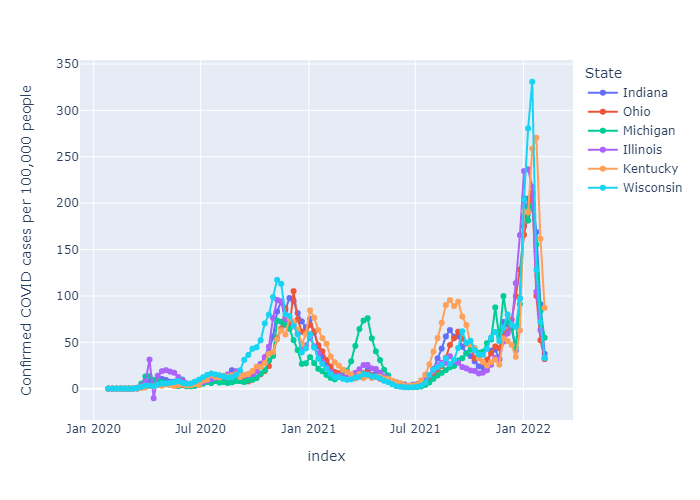

In [96]:
fig = px.line(confirmed, x=confirmed.index, y='New_Confirmed_per_100000', color='State', markers=True, 
              labels={"New_Confirmed_per_100000":"Confirmed COVID cases per 100,000 people",
                     "State": "State"})
#display plot
fig.write_image("images/US normalized weekly cases.png")
Image(filename="images/US normalized weekly cases.png")

As we can see, the trend for cases is similar for all 5 states, though Wisconsin seems to peak slightly higher when all states are spiking. Our first major spike in COVID cases occurs from October 2020 to January 2021. This coincides with a number of major holidays for the United States, where large numbers of people were traveling and visiting family. This would indicate that the spike is at least partially caused by the amount of travel. These were also colder months, where people stayed inside more. We know that the virus transmits more effectively indoors, so people visiting each other indoors could have contributed to the spread. We can then see that the COVID vaccines contributed to a major decreases in cases. 

For some reason, Michigan in April 2021 had a large spike in cases. After doing some research, there is not a concrete reason for why this occurred. Articles even point out that this is in stark contrast to the rest of the country. Health officials hypothesized that it could be a combination of laxed mandates due to the vaccines, families on spring break, and a particular COVID variant called B.1.1.7.

Cases continued to drop until late summer of 2021, starting in August. Cases began to rise again, due to the onset of the Delta variant of COVID. Cases waned a little until October 2021, when all states began sharply increasing in cases. This was when the Omicron variant hit the United States, compounded by similar factors that we saw the year prior, namely holidays, indoor living, and increased travel. These spikes were the largest by far, but it appears that Omicron came in quickly and left, as cases dropped dramatically in February 2022.

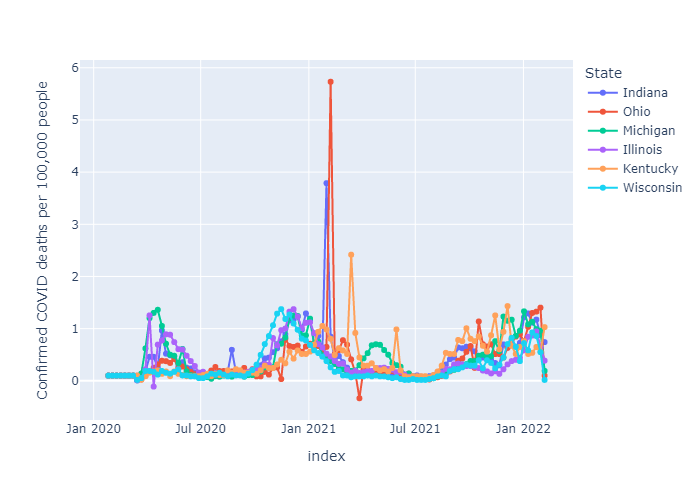

In [103]:
fig2 = px.line(confirmed, x=confirmed.index, y='New_Deaths_per_100000', color='State', markers=True, 
              labels={"New_Deaths_per_100000":"Confirmed COVID deaths per 100,000 people",
                     "State": "State"})
#display plot
fig2.write_image("images/US normalized weekly deaths.png")
Image(filename="images/US normalized weekly deaths.png")

For COVID deaths, our data looks a tad different. It should be noted that confirming COVID deaths is likely more difficult, as patients can die from other factors that the hospitals do not realize was caused by COVID, so numbers here are likely less accurate. Unsurprisingly, deaths spiked early in April 2020 as that was when COVID was first in full swing as lockdowns finally were put in place by states. The rise of deaths in October 2021 to January 2021 mirrors what we saw above in cases. 

For some reason, Indiana on January 31st 2021, Ohio on February 7th 2021, and Kentucky on March 14th 2021 had large spikes in deaths. However, deaths immediately drop back down. Nothing concrete was found after conducting research, and it is odd that the death rates dropped immediately. This leads back to the less accurate data noted earlier; it's possible that these days were "catch-up" days, where hospitals confirmed deaths that should have been confirmed earlier in the week. It's also entirely possible that a larger number of people just so happened to die on those particular days.

Deaths began to rise a little bit in September 2021 thanks to Delta variant, but it was the Omicron variant that really spikes cases up again in October 2021. This is maintained until a drop in February 2022, similar to cases. Interestingly, the spikes are about equal to what we saw in April 2020, despite much higher number of cases. This provides potential evidence that Omicron is much less deadly than the original COVID virus.

Now let's look at the counties in Indiana. Let's first see which counties had the most cases and deaths. Since the original data was an aggregate for cases and deaths, we can easily see totals by looking at the final date for each county.

In [28]:
final_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
final_covid = final_covid[final_covid["Date"].isin(["2022-02-07"])].reset_index(drop=True)
final_covid

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
0,18001,adams county,IN,2022-02-07,7509,107,35777
1,18003,allen county,IN,2022-02-07,101761,1094,379299
2,18005,bartholomew county,IN,2022-02-07,20773,233,83779
3,18007,benton county,IN,2022-02-07,2410,21,8748
4,18009,blackford county,IN,2022-02-07,3040,66,11758
...,...,...,...,...,...,...,...
87,18175,washington county,IN,2022-02-07,5796,75,28036
88,18177,wayne county,IN,2022-02-07,18706,319,65884
89,18179,wells county,IN,2022-02-07,6416,127,28296
90,18181,white county,IN,2022-02-07,6657,88,24102


If we sort by Confirmed and look at the tail, we can now see the highest infected counties. 

In [41]:
final_covid.sort_values("Confirmed").tail()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
70,18141,st. joseph county,IN,2022-02-07,69301,817,271826
28,18057,hamilton county,IN,2022-02-07,79781,611,338011
1,18003,allen county,IN,2022-02-07,101761,1094,379299
44,18089,lake county,IN,2022-02-07,104518,1705,485493
48,18097,marion county,IN,2022-02-07,220797,2799,964582


The above shows the top 5 counties in Indiana in regards to total COVID cases throughout the pandemic. What about deaths?

In [40]:
final_covid.sort_values("Deaths").tail()

,countyFIPS,County_Name,State,Date,Confirmed,Deaths,population
19,18039,elkhart county,IN,2022-02-07,53390,693,206341
70,18141,st. joseph county,IN,2022-02-07,69301,817,271826
1,18003,allen county,IN,2022-02-07,101761,1094,379299
44,18089,lake county,IN,2022-02-07,104518,1705,485493
48,18097,marion county,IN,2022-02-07,220797,2799,964582


Interestingly, hamilton county no longer remains in the top 5 when looking at deaths, replaced by elkhart county. For our analysis we're going to focus on the top 5 counties by total cases, not deaths. We'll start with st. joseph county.

In [98]:
joseph_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
joseph_covid = joseph_covid[joseph_covid["County_Name"].isin(["st. joseph county"])].reset_index(drop=True)

#Get new cases
joseph_covid["New_Confirmed"]=joseph_covid["Confirmed"].diff()

#New deaths
joseph_covid["New_Deaths"]=joseph_covid["Deaths"].diff()

#Removing NA
joseph_covid.New_Confirmed[0]=0.0
joseph_covid.New_Deaths[0]=0.0

#Remove unneeded columns prior to resampling
joseph_covid_trim=joseph_covid.drop(columns=['countyFIPS','County_Name','State','population','Confirmed','Deaths'])
joseph_covid_trim = joseph_covid_trim.drop([0,1,2,3])
joseph_covid_trim

,Date,New_Confirmed,New_Deaths
4,2020-01-26,0.0,0.0
5,2020-01-27,0.0,0.0
6,2020-01-28,0.0,0.0
7,2020-01-29,0.0,0.0
8,2020-01-30,0.0,0.0
...,...,...,...
743,2022-02-03,185.0,3.0
744,2022-02-04,105.0,3.0
745,2022-02-05,0.0,0.0
746,2022-02-06,0.0,0.0


Just like with the state data, we now have the daily information for a single county. We're going to make sure we get population for the county, then perform the same transformation to get normalized and log normalized values for cases and deaths.

In [52]:
joseph_pop=joseph_covid.population[0]
joseph_pop

271826

In [73]:
joseph_weekly_avg = joseph_covid_trim.resample('W-Sun',on='Date',label='left',closed='left').mean()
joseph_weekly_avg.New_Confirmed = joseph_weekly_avg.New_Confirmed.round()
joseph_weekly_avg.New_Deaths = joseph_weekly_avg.New_Deaths.round()
joseph_weekly_avg
joseph_weekly_avg['New_Confirmed_per_100000'] = joseph_weekly_avg.New_Confirmed/joseph_pop *100000
joseph_weekly_avg['New_Deaths_per_100000'] = joseph_weekly_avg.New_Deaths/joseph_pop *100000
x=len(joseph_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if joseph_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        joseph_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if joseph_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        joseph_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
joseph_weekly_avg['lognormal_Confirmed'] = np.log10(joseph_weekly_avg.New_Confirmed_per_100000)
joseph_weekly_avg['lognormal_Deaths'] = np.log10(joseph_weekly_avg.New_Deaths_per_100000)
joseph_weekly_avg
joseph_weekly_avg['County']='st. joseph county'
joseph_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
Date,,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
...,...,...,...,...,...,...,...
2022-01-09,485.0,3.0,178.422962,1.103647,2.251451,0.042830,st. joseph county
2022-01-16,485.0,3.0,178.422962,1.103647,2.251451,0.042830,st. joseph county
2022-01-23,347.0,1.0,127.655191,0.367882,2.106038,-0.434291,st. joseph county


Now we need to do so for the rest of the counties. Like with the states, I'm going to put the all of the code in one line, since the only alterations are with county name. 

Hamilton County:

In [99]:
hamilton_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
hamilton_covid = hamilton_covid[hamilton_covid["County_Name"].isin(["hamilton county"])].reset_index(drop=True)

#Get new cases
hamilton_covid["New_Confirmed"]=hamilton_covid["Confirmed"].diff()

#New deaths
hamilton_covid["New_Deaths"]=hamilton_covid["Deaths"].diff()

#Removing NA
hamilton_covid.New_Confirmed[0]=0.0
hamilton_covid.New_Deaths[0]=0.0

#Remove unneeded columns prior to resampling
hamilton_covid_trim=hamilton_covid.drop(columns=['countyFIPS','County_Name','State','population','Confirmed','Deaths'])
hamilton_covid_trim = hamilton_covid_trim.drop([0,1,2,3])

#Getting population
hamilton_pop=hamilton_covid.population[0]

hamilton_weekly_avg = hamilton_covid_trim.resample('W-Sun',on='Date',label='left',closed='left').mean()
hamilton_weekly_avg.New_Confirmed = hamilton_weekly_avg.New_Confirmed.round()
hamilton_weekly_avg.New_Deaths = hamilton_weekly_avg.New_Deaths.round()
hamilton_weekly_avg['New_Confirmed_per_100000'] = hamilton_weekly_avg.New_Confirmed/hamilton_pop *100000
hamilton_weekly_avg['New_Deaths_per_100000'] = hamilton_weekly_avg.New_Deaths/hamilton_pop *100000
x=len(hamilton_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if hamilton_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        hamilton_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if hamilton_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        hamilton_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
hamilton_weekly_avg['lognormal_Confirmed'] = np.log10(hamilton_weekly_avg.New_Confirmed_per_100000)
hamilton_weekly_avg['lognormal_Deaths'] = np.log10(hamilton_weekly_avg.New_Deaths_per_100000)
hamilton_weekly_avg['County']='hamilton county'
hamilton_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
Date,,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,hamilton county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,hamilton county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,hamilton county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,hamilton county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,hamilton county
...,...,...,...,...,...,...,...
2022-01-09,790.0,3.0,233.720204,0.887545,2.368696,-0.051810,hamilton county
2022-01-16,711.0,2.0,210.348184,0.591697,2.322939,-0.227901,hamilton county
2022-01-23,550.0,1.0,162.716598,0.295848,2.211432,-0.528931,hamilton county


Allen County:

In [100]:
allen_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
allen_covid = allen_covid[allen_covid["County_Name"].isin(["allen county"])].reset_index(drop=True)

#Get new cases
allen_covid["New_Confirmed"]=allen_covid["Confirmed"].diff()

#New deaths
allen_covid["New_Deaths"]=allen_covid["Deaths"].diff()

#Removing NA
allen_covid.New_Confirmed[0]=0.0
allen_covid.New_Deaths[0]=0.0

#Remove unneeded columns prior to resampling
allen_covid_trim=allen_covid.drop(columns=['countyFIPS','County_Name','State','population','Confirmed','Deaths'])
allen_covid_trim = allen_covid_trim.drop([0,1,2,3])

#Getting population
allen_pop=allen_covid.population[0]

allen_weekly_avg = allen_covid_trim.resample('W-Sun',on='Date',label='left',closed='left').mean()
allen_weekly_avg.New_Confirmed = allen_weekly_avg.New_Confirmed.round()
allen_weekly_avg.New_Deaths = allen_weekly_avg.New_Deaths.round()
allen_weekly_avg['New_Confirmed_per_100000'] = allen_weekly_avg.New_Confirmed/allen_pop *100000
allen_weekly_avg['New_Deaths_per_100000'] = allen_weekly_avg.New_Deaths/allen_pop *100000
x=len(allen_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if allen_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        allen_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if allen_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        allen_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
allen_weekly_avg['lognormal_Confirmed'] = np.log10(allen_weekly_avg.New_Confirmed_per_100000)
allen_weekly_avg['lognormal_Deaths'] = np.log10(allen_weekly_avg.New_Deaths_per_100000)
allen_weekly_avg['County']='allen county'
allen_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
Date,,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,allen county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,allen county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,allen county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,allen county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,allen county
...,...,...,...,...,...,...,...
2022-01-09,1003.0,3.0,264.435182,0.790933,2.422319,-0.101860,allen county
2022-01-16,969.0,3.0,255.471277,0.790933,2.407342,-0.101860,allen county
2022-01-23,651.0,4.0,171.632406,1.054577,2.234599,0.023078,allen county


Lake County:

In [101]:
lake_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
lake_covid = lake_covid[lake_covid["County_Name"].isin(["lake county"])].reset_index(drop=True)

#Get new cases
lake_covid["New_Confirmed"]=lake_covid["Confirmed"].diff()

#New deaths
lake_covid["New_Deaths"]=lake_covid["Deaths"].diff()

#Removing NA
lake_covid.New_Confirmed[0]=0.0
lake_covid.New_Deaths[0]=0.0

#Remove unneeded columns prior to resampling
lake_covid_trim=lake_covid.drop(columns=['countyFIPS','County_Name','State','population','Confirmed','Deaths'])
lake_covid_trim = lake_covid_trim.drop([0,1,2,3])

#Getting population
lake_pop=lake_covid.population[0]

lake_weekly_avg = lake_covid_trim.resample('W-Sun',on='Date',label='left',closed='left').mean()
lake_weekly_avg.New_Confirmed = lake_weekly_avg.New_Confirmed.round()
lake_weekly_avg.New_Deaths = lake_weekly_avg.New_Deaths.round()
lake_weekly_avg['New_Confirmed_per_100000'] = lake_weekly_avg.New_Confirmed/lake_pop *100000
lake_weekly_avg['New_Deaths_per_100000'] = lake_weekly_avg.New_Deaths/lake_pop *100000
x=len(lake_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if lake_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        lake_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if lake_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        lake_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
lake_weekly_avg['lognormal_Confirmed'] = np.log10(lake_weekly_avg.New_Confirmed_per_100000)
lake_weekly_avg['lognormal_Deaths'] = np.log10(lake_weekly_avg.New_Deaths_per_100000)
lake_weekly_avg['County']='lake county'
lake_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
Date,,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,lake county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,lake county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,lake county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,lake county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,lake county
...,...,...,...,...,...,...,...
2022-01-09,755.0,9.0,155.512026,1.853786,2.191764,0.268060,lake county
2022-01-16,495.0,10.0,101.958216,2.059762,2.008422,0.313817,lake county
2022-01-23,292.0,10.0,60.145048,2.059762,1.779200,0.313817,lake county


Marion County:

In [102]:
marion_covid = data[data["State"].isin(["IN"])].reset_index(drop=True)
marion_covid = marion_covid[marion_covid["County_Name"].isin(["marion county"])].reset_index(drop=True)

#Get new cases
marion_covid["New_Confirmed"]=marion_covid["Confirmed"].diff()

#New deaths
marion_covid["New_Deaths"]=marion_covid["Deaths"].diff()

#Removing NA
marion_covid.New_Confirmed[0]=0.0
marion_covid.New_Deaths[0]=0.0

#Remove unneeded columns prior to resampling
marion_covid_trim=lake_covid.drop(columns=['countyFIPS','County_Name','State','population','Confirmed','Deaths'])
marion_covid_trim = marion_covid_trim.drop([0,1,2,3])

#Getting population
marion_pop=lake_covid.population[0]

marion_weekly_avg = marion_covid_trim.resample('W-Sun',on='Date',label='left',closed='left').mean()
marion_weekly_avg.New_Confirmed = marion_weekly_avg.New_Confirmed.round()
marion_weekly_avg.New_Deaths = marion_weekly_avg.New_Deaths.round()
marion_weekly_avg['New_Confirmed_per_100000'] = marion_weekly_avg.New_Confirmed/marion_pop *100000
marion_weekly_avg['New_Deaths_per_100000'] = marion_weekly_avg.New_Deaths/marion_pop *100000
x=len(marion_weekly_avg.New_Confirmed_per_100000)

#Since log values of 0 will be negative infinity, transforming 0.000000 to 0.100000
for i in range(x):
    if marion_weekly_avg.New_Confirmed_per_100000[i]==0.000000:
        marion_weekly_avg.New_Confirmed_per_100000[i] =0.100000
    if marion_weekly_avg.New_Deaths_per_100000[i]==0.000000:
        marion_weekly_avg.New_Deaths_per_100000[i] =0.100000
        
#log normalized values (base 10 log)
marion_weekly_avg['lognormal_Confirmed'] = np.log10(marion_weekly_avg.New_Confirmed_per_100000)
marion_weekly_avg['lognormal_Deaths'] = np.log10(marion_weekly_avg.New_Deaths_per_100000)
marion_weekly_avg['County']='marion county'
marion_weekly_avg

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
Date,,,,,,,
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,marion county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,marion county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,marion county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,marion county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,marion county
...,...,...,...,...,...,...,...
2022-01-09,755.0,9.0,155.512026,1.853786,2.191764,0.268060,marion county
2022-01-16,495.0,10.0,101.958216,2.059762,2.008422,0.313817,marion county
2022-01-23,292.0,10.0,60.145048,2.059762,1.779200,0.313817,marion county


Like with the states, we now need to merge the counties back together for plotting purposes.

In [80]:
all_counties=joseph_weekly_avg.merge(hamilton_weekly_avg,how='outer')
all_counties=all_counties.merge(allen_weekly_avg,how='outer')
all_counties=all_counties.merge(lake_weekly_avg,how='outer')
all_counties=all_counties.merge(marion_weekly_avg,how='outer')
all_counties

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
0,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
1,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
3,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
4,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
...,...,...,...,...,...,...,...
530,755.0,9.0,155.512026,1.853786,2.191764,0.268060,marion county
531,495.0,10.0,101.958216,2.059762,2.008422,0.313817,marion county
532,292.0,10.0,60.145048,2.059762,1.779200,0.313817,marion county
533,159.0,6.0,32.750215,1.235857,1.515214,0.091968,marion county


Like before, we need to pull back in the Date as an index.

In [81]:
all_counties.index=Dates4
all_counties

,New_Confirmed,New_Deaths,New_Confirmed_per_100000,New_Deaths_per_100000,lognormal_Confirmed,lognormal_Deaths,County
2020-01-26,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-02,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-09,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-16,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
2020-02-23,0.0,0.0,0.100000,0.100000,-1.000000,-1.000000,st. joseph county
...,...,...,...,...,...,...,...
2022-01-09,755.0,9.0,155.512026,1.853786,2.191764,0.268060,marion county
2022-01-16,495.0,10.0,101.958216,2.059762,2.008422,0.313817,marion county
2022-01-23,292.0,10.0,60.145048,2.059762,1.779200,0.313817,marion county
2022-01-30,159.0,6.0,32.750215,1.235857,1.515214,0.091968,marion county


Now it's time to generate our plots for cases and deaths. We'll also be generating plots for the log cases and deaths this time around.

Cases per 100000:

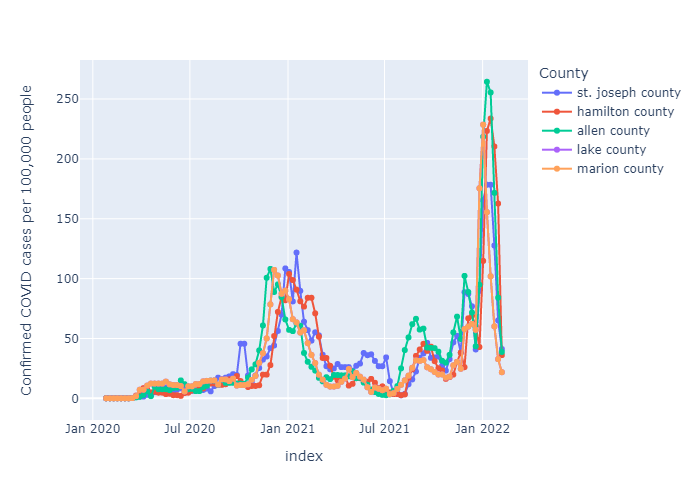

In [104]:
fig3 = px.line(all_counties, x=all_counties.index, y='New_Confirmed_per_100000', color='County', markers=True, 
              labels={"New_Confirmed_per_100000":"Confirmed COVID cases per 100,000 people",
                     "County": "County"})
#display plot
fig3.write_image("images/Indiana normalized weekly cases.png")
Image(filename="images/Indiana normalized weekly cases.png")

The number of cases by county mirror what we saw by state, with similar spikes and drops. In particular, they seem to match Indiana as a whole very closely. 

Deaths per 10000:

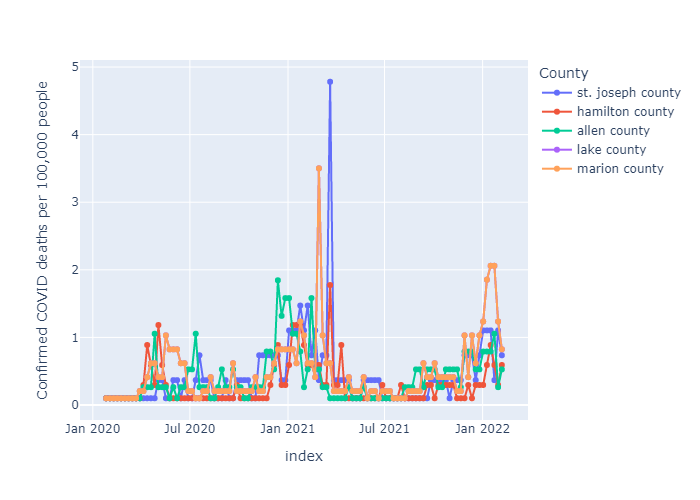

In [108]:
fig4 = px.line(all_counties, x=all_counties.index, y='New_Deaths_per_100000', color='County', markers=True, 
              labels={"New_Deaths_per_100000":"Confirmed COVID deaths per 100,000 people",
                     "County": "County"})
#display plot
fig4.write_image("images/Indiana normalized weekly deaths.png")
Image(filename="images/Indiana normalized weekly deaths.png")

Again, like with the cases, the counties mirror the states and Indiana specifically. We again see a couple of days with odd spikes that immediately go down, which could be down to "catch-up" or just an unlucky number of deaths. 

Log of Cases per 100000:

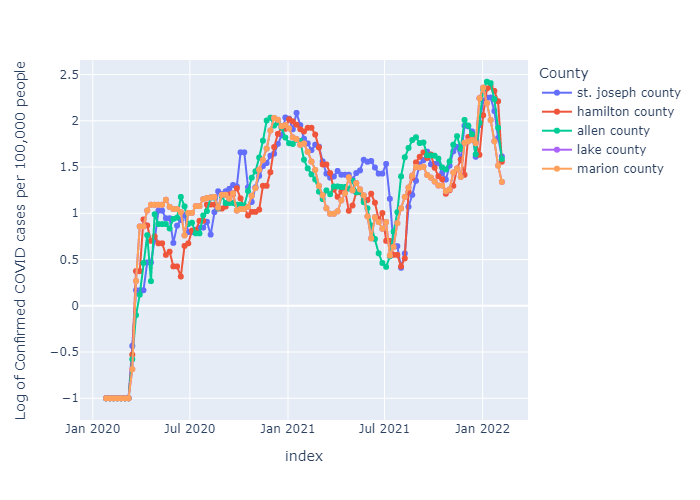

In [107]:
fig5 = px.line(all_counties, x=all_counties.index, y='lognormal_Confirmed', color='County', markers=True, 
              labels={"lognormal_Confirmed":"Log of Confirmed COVID cases per 100,000 people",
                     "County": "County"})
#display plot
fig5.write_image("images/Indiana log normalized weekly cases.png")
Image(filename="images/Indiana log normalized weekly cases.png")

The log tells sort of the inverse of the story from the previous graphs. It's really showing that we've only had one major dip in cases, from January 2021 to July/August 2021. This coincides with the vaccine roll-out, and the drop in COVID cases in the summer before the onset of Delta. We can start to see another major dip beginning in February 2022. 

Log of Deaths per 100000

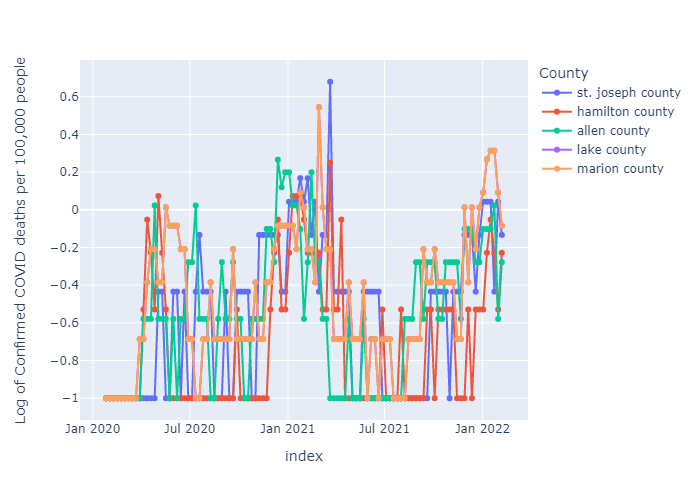

In [109]:
fig6 = px.line(all_counties, x=all_counties.index, y='lognormal_Deaths', color='County', markers=True, 
              labels={"lognormal_Deaths":"Log of Confirmed COVID deaths per 100,000 people",
                     "County": "County"})
#display plot
fig6.write_image("images/Indiana log normalized weekly deaths.png")
Image(filename="images/Indiana log normalized weekly deaths.png")

The log of deaths isn't extremely useful, since we have a number of negative log deaths due to very low COVID deaths on particular days. It also appears to be far more erratic between counties, and we less a less uniform pattern from county to county. This makes sense when we think about data being less accurate. Counties will be less accurate on different days from each other. 